In [1]:
import overpy
import pandas as pd
import numpy as np

from shapely.geometry import Polygon
from shapely.ops import polygonize
from shapely.geometry import LineString
from shapely.geometry import Point

import geopandas as gpd
import pyproj

from matplotlib import pylab as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm

import contextily as ctx

from collections import deque

import networkx as nx

import cv2

In [2]:
api = overpy.Overpass()

In [3]:
query_input = [58.3405, 26.6445, 58.4046, 26.8481]

In [4]:
result = api.query("""
    [out:json][timeout:25];
    (
      way["highway"](58.3405, 26.6445, 58.4046, 26.8481);
      relation["highway"](58.3405, 26.6445, 58.4046, 26.8481);
    );
    (._;>;);
    out;
    """)

In [5]:
#result = api.query("""
#    [out:json][timeout:25];
#    area[name = "Tartu linn"];
#    (
#      way(area)["highway"];
#      relation(area)["highway"];
#    );
#    (._;>;);
#    out;
#    """)

In [6]:
#min_lat = float(min(result.nodes, key=lambda x: x.lat).lat)
#max_lat = float(max(result.nodes, key=lambda x: x.lat).lat)
#min_lon = float(min(result.nodes, key=lambda x: x.lon).lon)
#max_lon = float(max(result.nodes, key=lambda x: x.lon).lon)
#bbox = [min_lon, min_lat, max_lon, max_lat]
#bbox

In [7]:
def nodelist_to_edges(list_of_nodes):
    '''
    Takes a list of nodes in a way and converts them into node pairs (including ID and coord. of each node), imitating an edge
    
    In the following example, nodes [11228194, 8223498, 322959398] turn into
    [[11228194, 8223498], [8223498, 322959398]]
    
    Example input: 
    [<overpy.Node id=11228194 lat=58.4218993 lon=26.5053693>, 
     <overpy.Node id=8223498 lat=58.4217486 lon=26.5060318>, 
     <overpy.Node id=322959398 lat=58.4215384 lon=26.5069523>]
     
    Example output:
    [[[11228194, Decimal('26.5053693'), Decimal('58.4218993')], [8223498, Decimal('26.5060318'), Decimal('58.4217486')]],
    [[8223498, Decimal('26.5060318'), Decimal('58.4217486')], [322959398, Decimal('26.5069523'), Decimal('58.4215384')]]]
    '''
    
    x = list_of_nodes
    index_pairs = [0, len(x) - 1]
    index_pairs[1:1] = np.repeat(range(1, len(x) - 1), 2)
    index_pairs = list(zip(index_pairs[::2], index_pairs[1::2]))
    return [[[x[a].id, x[a].lon, x[a].lat], [x[b].id, x[b].lon, x[b].lat]] for a, b in index_pairs]

def make_line(row):
    '''
    Converts two coordinates into a LineString
    TODO: Fix warning "Convert the '.coords' to a numpy array instead."
    '''
    coordinates = np.asarray([(row["A_lon"], row["A_lat"]), (row["B_lon"], row["B_lat"])])
    return LineString(coordinates)

node_cols = ["id", "lon", "lat"]
df_nodes = pd.DataFrame([[getattr(node, att) for att in node_cols] for node in result.nodes])\
    .rename(columns = dict(zip(range(0, 3), node_cols)))

# Convert coordinates into whatever that is not Decimal()
df_nodes[["lon", "lat"]] = df_nodes[["lon", "lat"]].apply(pd.to_numeric)

way_cols = ["roadID", "tag", "nodelist"]

# Get all edges alongside the two nodes they consist of
df_ways = pd.DataFrame([[way.id, way.tags.get("highway"), nodelist_to_edges(way.nodes)] for way in result.ways])\
    .rename(columns = dict(zip(range(0, 3), way_cols))).explode("nodelist").reset_index(drop = True)

# Separate start and end point of each edge into new column A and B
df_ways[["A","B"]] = pd.DataFrame(df_ways["nodelist"].tolist())
df_ways = df_ways.drop(columns = ["nodelist"])

# Separate the ID and longitude-latitude coordinates of each _start_ point into new columns
df_ways[["A_id", "A_lon", "A_lat"]] = pd.DataFrame(df_ways["A"].tolist())
df_ways = df_ways.drop(columns = ["A"])

# Separate the ID and longitude-latitude coordinates of each _end_ point into new columns
df_ways[["B_id", "B_lon", "B_lat"]] = pd.DataFrame(df_ways["B"].tolist())
df_ways = df_ways.drop(columns = ["B"])

# Convert coordinates into whatever that is not Decimal()
df_ways[["A_lon", "A_lat", "B_lon", "B_lat"]] = df_ways[["A_lon", "A_lat", "B_lon", "B_lat"]].apply(pd.to_numeric)

# Calculate distances (weights) of each edge
df_ways["distance"] = np.linalg.norm(df_ways[["A_lon", "A_lat"]].values - df_ways[["B_lon", "B_lat"]].values, axis = 1)

# Get separate ID for each edge
df_ways = df_ways.reset_index().rename(columns={'index': 'edgeID'})

# Convert coordinates into linestrings under geometry column
df_ways["geometry"] = df_ways.apply(make_line, axis=1)

# All roads into GeoDF
proj_epsg_4326 = pyproj.CRS.from_string("epsg:4326")
edges_gpd = gpd.GeoDataFrame(geometry=df_ways["geometry"], crs=proj_epsg_4326)

#display(df_ways)
#display(edges_gpd)

C:\Users\ingva\anaconda3\envs\ITS\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<IPython.core.display.Javascript object>


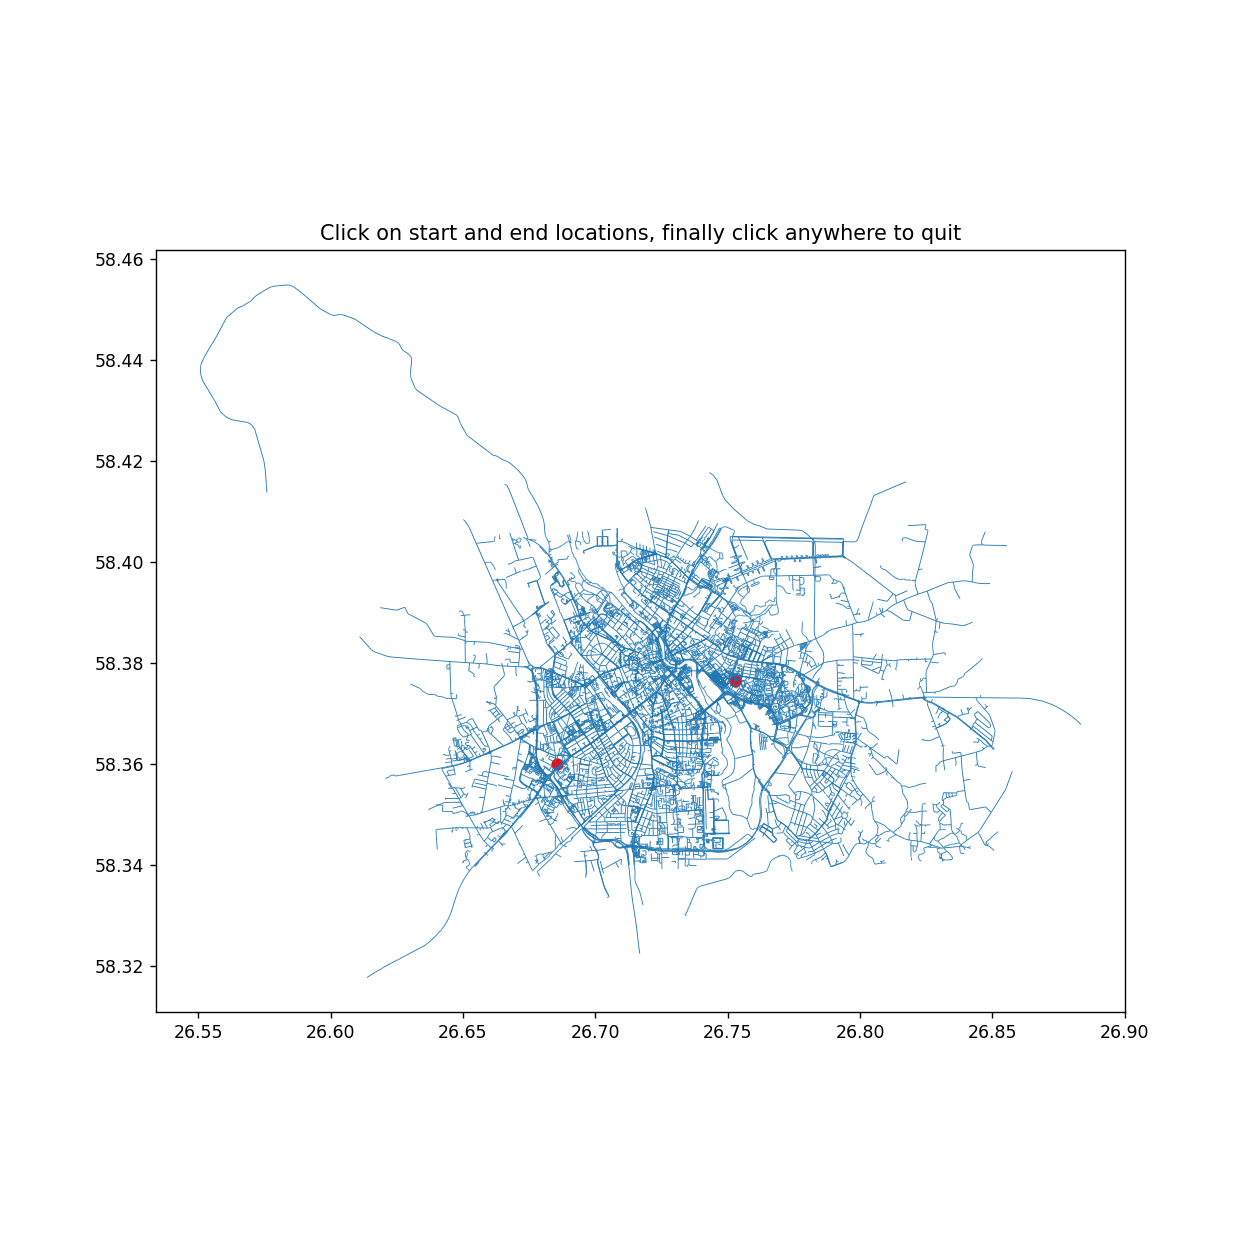

In [8]:
%matplotlib notebook

# Plot general area
fig, ax = plt.subplots(1,1,figsize=(10, 10))
edges_gpd.plot(ax = ax, figsize=(10, 10), linewidth=0.5)

click_count = 0
startXY = None
endXY = None

def onclick(event):
    global click_count, startXY, endXY
    
    if click_count == 0:
        startXY = (event.xdata, event.ydata)
        plt.scatter(event.xdata, event.ydata, color="red")
    if click_count == 1:
        endXY = (event.xdata, event.ydata)
        plt.scatter(event.xdata, event.ydata, color="red")
    if click_count == 2:
        event.canvas.mpl_disconnect(cid)
        plt.close()
    click_count += 1

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.title("Click on start and end locations, finally click anywhere to quit")
plt.show()

#plt.savefig('roads.jpg', dpi = 200)

In [9]:
# Find closest nodes for startXY and endXY

dist2coord = df_nodes.copy()

dist2coord["dist"] = np.linalg.norm(startXY - df_nodes[["lon", "lat"]].apply(pd.to_numeric).values, axis = 1)
start_node_ID = dist2coord[dist2coord.dist == dist2coord.dist.min()]

dist2coord["dist"] = np.linalg.norm(endXY - df_nodes[["lon", "lat"]].apply(pd.to_numeric).values, axis = 1)
end_node_ID = dist2coord[dist2coord.dist == dist2coord.dist.min()]

start_node_ID = int(start_node_ID["id"])
end_node_ID = int(end_node_ID["id"])

In [10]:
# Create a graph
G = nx.from_pandas_edgelist(df_ways, "A_id", "B_id", ["distance", "edgeID"])

# Add coordinates to each node so Astar algorithm can calculate heuristic
node_attributes = df_nodes.set_index('id').T.to_dict('list')
nx.set_node_attributes(G, node_attributes, name="coords")

In [11]:
# Implement A*

def astar_heuristic(start_node_id, end_node_id):
    start_coord = G.nodes()[start_node_id].get("coords")
    end_coord = G.nodes()[end_node_id].get("coords")
    return np.linalg.norm(np.asarray(start_coord) - np.asarray(end_coord))

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from.keys():
        current = came_from[current]
        total_path.insert(0, current)
    return total_path

def poor_mans_a_star(start, end, h):
    open_set = set([start])
    came_from_dict = dict()

    g_score_dict = {node_id: np.inf for node_id in list(G.nodes())}
    g_score_dict[start] = 0

    f_score_dict = {node_id: np.inf for node_id in list(G.nodes())}
    f_score_dict[start] = h(start, end)
    
    edges_per_step = []

    while len(open_set) != 0:
        current = None
        currentMin = np.inf
        for x in open_set:
            if f_score_dict.get(x) < currentMin:
                currentMin = f_score_dict.get(x)
                current = x

        if current == end:
            return reconstruct_path(came_from_dict, current), edges_per_step

        open_set.remove(current)
        edges_this_step = []
        for neighbor in G.neighbors(current):
            #edges_this_step.append(G.get_edge_data(current, neighbor).get("edgeID"))
            tentative_g_score = g_score_dict[current] + \
                                G.get_edge_data(current, neighbor).get("distance")
            if tentative_g_score < g_score_dict[neighbor]:
                edges_this_step.append(G.get_edge_data(current, neighbor).get("edgeID"))
                came_from_dict[neighbor] = current
                g_score_dict[neighbor] = tentative_g_score
                f_score_dict[neighbor] = g_score_dict[neighbor] + h(neighbor, end)

                if neighbor not in open_set:
                    open_set.add(neighbor)
        edges_per_step.append(edges_this_step)
                    
    raise Exception('No path found.')

In [12]:
# networkx implementation, like 10 times faster
#shortest_path = nx.astar_path(G, start_node_ID, end_node_ID, weight="distance")

# Self-implemented
shortest_path, edge_history = poor_mans_a_star(start_node_ID, end_node_ID, astar_heuristic)

# Convert OSM node IDs in found shortest path to IDs of edges
shortest_path_IDs = []
for i in range(len(shortest_path) - 1):
    shortest_path_IDs.append(G.get_edge_data(shortest_path[i], shortest_path[i+1]).get("edgeID"))

# Generate colors for path-finding visualisation
colors = cm.get_cmap("viridis")(np.linspace(0, 1, len(edge_history)))

# Append shortest path to edge_history so it would also be drawn during animation
for i in shortest_path_IDs:
    edge_history.append([i])
    
# Get locations to zoom into for the general area where a path was found
margin_percent = 0.05

min_lat = min([G.nodes()[node].get("coords")[0] for node in shortest_path])
max_lat = max([G.nodes()[node].get("coords")[0] for node in shortest_path])
lat_margin = (max_lat - min_lat) * margin_percent

min_lon = min([G.nodes()[node].get("coords")[1] for node in shortest_path])
max_lon = max([G.nodes()[node].get("coords")[1] for node in shortest_path])
lon_margin = (max_lon - min_lon) * margin_percent

<IPython.core.display.Javascript object>


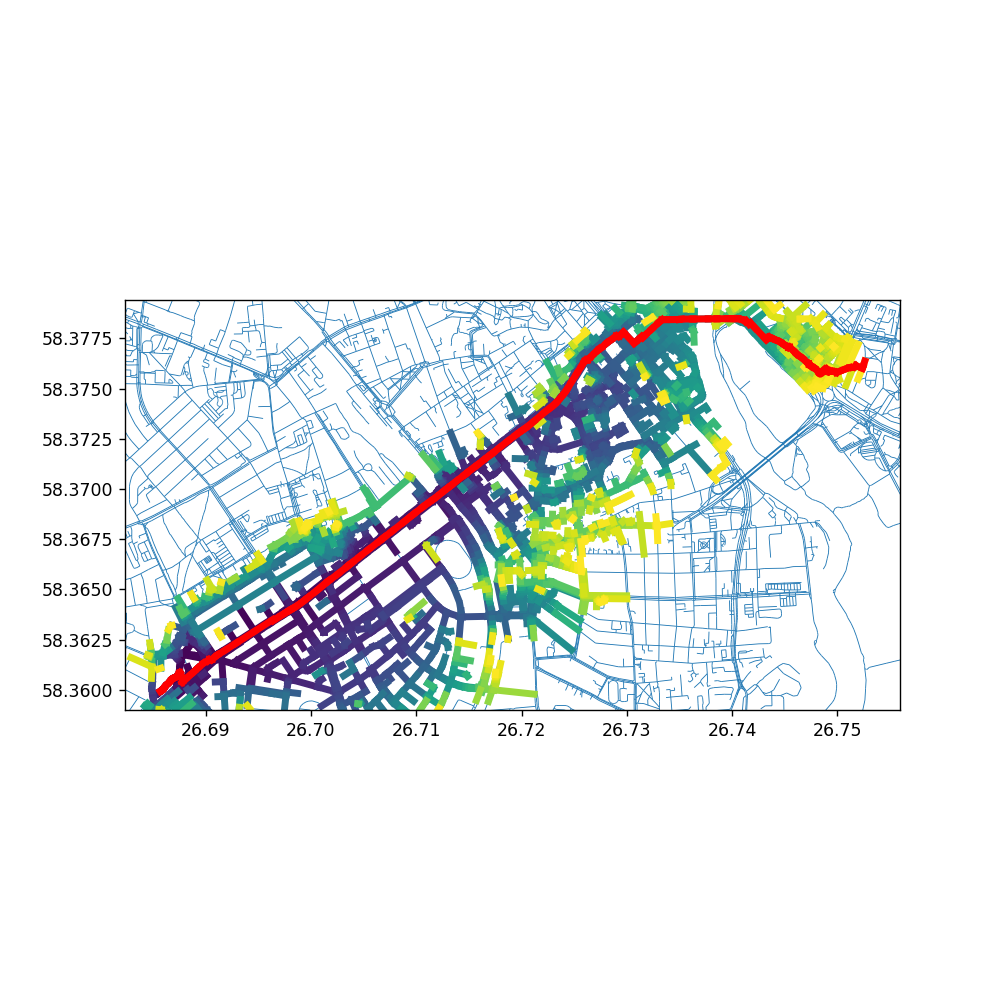

In [17]:
%matplotlib notebook

# Init plot
fig, ax = plt.subplots(1,1,figsize=(8,8))

# Draw entire map
edges_gpd = gpd.GeoDataFrame(geometry=df_ways["geometry"], crs=proj_epsg_4326)
edges_gpd.plot(ax = ax, linewidth=0.5)

# Limit map view to area where shortest path was found 
plt.xlim(min_lat - lat_margin, max_lat + lat_margin)
plt.ylim(min_lon - lon_margin, max_lon + lon_margin)

# Draw visualisation of how shortest path was found and then also plot shortest path itself
def animate(i):
    # This raw plt.plot() vs gpd.plot() is a bit faster.
    art = []
    color = colors[i] if i < len(colors) else "red"
    for x in edges_gpd.iloc[edge_history[i]].values:
        x1 = x[0].coords[0][0]
        x2 = x[0].coords[1][0]
        y1 = x[0].coords[0][1]
        y2 = x[0].coords[1][1]
        art.append(plt.plot((x1, x2), (y1, y2), color = color, linewidth = 4))
    return art

# Animation initialiser
ani = FuncAnimation(fig, animate, interval=0.2, repeat=False, blit=True, frames=len(edge_history))